In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ColabNotebooks/DL_fall23_yash/FinalRun_676/CSE-676-Project
%ls

/content/drive/MyDrive/ColabNotebooks/DL_fall23_yash/FinalRun_676/CSE-676-Project
data/  helpers/  LICENSE  README.md  seq2seq_gru_bahdanu.ipynb


In [3]:
# Imports
import pickle
import torch
import matplotlib.pyplot as plt
from torchtext.data.metrics import bleu_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Helper functions
from helpers.preprocessing import preprocess_data, split_data, normalize_data
from helpers.model import Encoder, AttentionDecoder
from helpers.training import prepare_dataloader, train
from helpers.evaluation import generate_translation, evaluate

In [5]:
# Global Variables
languages = ['eng', 'fra', 'spa', 'deu', 'por']
LANGUAGE1 = languages[0]
LANGUAGE2 = languages[4]
FILEPATH = f'data/{LANGUAGE1}-{LANGUAGE2}.txt'

# Model tuning parameters
HIDDEN_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT = 0.1


Data preprocessing

In [6]:
input_language, output_language, line_pairs = preprocess_data(FILEPATH, LANGUAGE1, LANGUAGE2)

train_pairs, test_pairs = split_data(line_pairs, test_size=0.2)

Number of translation pairs: 190639
Number of translation pairs after filter: 188883
Vocabulary - por: 21369
Vocabulary - eng: 12592
Number of training pairs: 151106
Number of testing pairs: 37777


Model

In [7]:
encoder = Encoder(input_language.n_words, HIDDEN_SIZE, DROPOUT).to(device)
decoder = AttentionDecoder(HIDDEN_SIZE, output_language.n_words, DROPOUT).to(device)

encoder, decoder

(Encoder(
   (encoder_layers): Sequential(
     (0): Embedding(21369, 128)
     (1): Dropout(p=0.1, inplace=False)
     (2): GRU(128, 128, batch_first=True)
   )
 ),
 AttentionDecoder(
   (embedding): Embedding(12592, 128)
   (attention): BahdanauAttention(
     (Wa): Linear(in_features=128, out_features=128, bias=True)
     (Ua): Linear(in_features=128, out_features=128, bias=True)
     (Va): Linear(in_features=128, out_features=1, bias=True)
   )
   (gru): GRU(256, 128, batch_first=True)
   (out): Linear(in_features=128, out_features=12592, bias=True)
   (dropout): Dropout(p=0.1, inplace=False)
 ))

Training

In [8]:
input_language, output_language, train_dataloader = prepare_dataloader(input_language, output_language, train_pairs, BATCH_SIZE)

losses_list, accuracies_list = train(train_dataloader, encoder, decoder, epochs=80, learning_rate=LEARNING_RATE, print_every=5, plot_every=5)


Epoch [5/80], Avg. Loss: 0.8320, Avg. Accuracy: 0.6870, Time for 5 Epochs: 12:40 minutes
Epoch [10/80], Avg. Loss: 0.3970, Avg. Accuracy: 0.8143, Time for 5 Epochs: 12:21 minutes
Epoch [15/80], Avg. Loss: 0.3082, Avg. Accuracy: 0.8451, Time for 5 Epochs: 12:22 minutes
Epoch [20/80], Avg. Loss: 0.2643, Avg. Accuracy: 0.8617, Time for 5 Epochs: 12:22 minutes
Epoch [25/80], Avg. Loss: 0.2368, Avg. Accuracy: 0.8725, Time for 5 Epochs: 12:21 minutes
Epoch [30/80], Avg. Loss: 0.2176, Avg. Accuracy: 0.8803, Time for 5 Epochs: 12:25 minutes
Epoch [35/80], Avg. Loss: 0.2035, Avg. Accuracy: 0.8864, Time for 5 Epochs: 12:31 minutes
Epoch [40/80], Avg. Loss: 0.1927, Avg. Accuracy: 0.8910, Time for 5 Epochs: 12:32 minutes
Epoch [45/80], Avg. Loss: 0.1838, Avg. Accuracy: 0.8950, Time for 5 Epochs: 12:34 minutes
Epoch [50/80], Avg. Loss: 0.1763, Avg. Accuracy: 0.8981, Time for 5 Epochs: 12:43 minutes
Epoch [55/80], Avg. Loss: 0.1701, Avg. Accuracy: 0.9010, Time for 5 Epochs: 12:40 minutes
Epoch [60/8

In [9]:
print( accuracies_list)
print(losses_list)

[0.48363459543683524, 0.6754603671224271, 0.7324355956311597, 0.7623846364756814, 0.781318407320088, 0.7954526296361696, 0.8066586748135062, 0.8153864173397777, 0.8236252430165194, 0.8301825851544968, 0.8358162205041612, 0.841359348560446, 0.8456380364886364, 0.8495183148606764, 0.8532752548623269, 0.855972727135595, 0.859489201681306, 0.862067772216213, 0.8647004696618665, 0.8663819532006307, 0.8689197067208764, 0.8710093604062535, 0.8724068994952, 0.8743625668933194, 0.8760112193550734, 0.8775817870931276, 0.8788524385060618, 0.8804833444397022, 0.8817096295323523, 0.8827575620174608, 0.8844115384376489, 0.885674203912932, 0.8861462615607539, 0.8873885185287064, 0.8885065497998635, 0.8892288334940873, 0.8899626524315849, 0.8909245142553424, 0.8920239116719803, 0.892654800746419, 0.8936202118757991, 0.8943691153621933, 0.8946069188389156, 0.8961029511588926, 0.8961100497701381, 0.8972591374654941, 0.8976531103896161, 0.8979184209849146, 0.898575042525118, 0.899252072572652, 0.89989006

Save Model

In [10]:
# Save models

encoder_filepath = f'saved_models/encoder-{LANGUAGE1}-{LANGUAGE2}-mx15.pth'
decoder_filepath = f'saved_models/decoder-{LANGUAGE1}-{LANGUAGE2}-mx15.pth'

torch.save(encoder.state_dict(), encoder_filepath)
torch.save(decoder.state_dict(), decoder_filepath)

Evaluation

In [11]:
# Evaluate random training pairs

encoder.eval()
decoder.eval()

references_corpus, candidate_corpus = evaluate(input_language, output_language, encoder, decoder,
                                               train_pairs, evaluate_train=True)

Input Sequence> eu estava apenas seguindo ordens
Target Sequence = ['i', 'was', 'just', 'following', 'orders']
Predicted sequence < ['i', 'was', 'just', 'following', 'orders']
Input Sequence> voce sabe assobiar ?
Target Sequence = ['do', 'you', 'know', 'how', 'to', 'whistle', '?']
Predicted sequence < ['do', 'you', 'know', 'how', 'to', 'whistle', '?']
Input Sequence> eu tenho um barco
Target Sequence = ['i', 'have', 'a', 'boat']
Predicted sequence < ['i', 'have', 'a', 'boat', 'by', 'boat']
Input Sequence> o tom sera que nem eu
Target Sequence = ['tom', 'is', 'going', 'to', 'like', 'me']
Predicted sequence < ['tom', 'is', 'going', 'to', 'say', 'that', 'i', 'm']
Input Sequence> eu sou jovem demais para fazer isso sozinho
Target Sequence = ['i', 'm', 'too', 'young', 'to', 'do', 'that', 'by', 'myself']
Predicted sequence < ['i', 'm', 'too', 'young', 'to', 'be', 'done', 'to', 'do', 'that', 'by', 'myself']
Input Sequence> suas revistas em quadrinhos estao na prateleira
Target Sequence = ['yo

In [12]:
# Evaluate testing pairs

candidate_corpus, references_corpus = evaluate(input_language, output_language, encoder, decoder,
                                                test_pairs, evaluate_train=False, iterations=len(test_pairs))

Streaming output truncated to the last 5000 lines.
Target Sequence = ['i', 'couldn', 't', 'find', 'it']
Predicted sequence < ['i', 'couldn', 't', 'find', 'find', 'find', 'find', 'find', 'myself']
Input Sequence> a porta esta aberta
Target Sequence = ['the', 'door', 'is', 'unlocked']
Predicted sequence < ['the', 'door', 'is', 'open', 'open']
Input Sequence> estes sao vossos
Target Sequence = ['these', 'are', 'yours']
Predicted sequence < ['these', 'are', 'your', 'opinion']
Input Sequence> eu nao tenho uma guitarra
Target Sequence = ['i', 'don', 't', 'have', 'a', 'guitar']
Predicted sequence < ['i', 'don', 't', 'have', 'the', 'guitar']
Input Sequence> tom disse que gostou da refeicao que mary preparou
Target Sequence = ['tom', 'said', 'he', 'd', 'enjoyed', 'the', 'meal', 'that', 'mary', 'had', 'prepared']
Predicted sequence < ['tom', 'said', 'he', 'liked', 'the', 'meal', 'that', 'mary', 'cooked', 'mary', 'cooked']
Input Sequence> nao conheco esse cara
Target Sequence = ['i', 'don', 't', 

Benchmark

In [13]:
#GRU with Bahdanau attention
bleu = bleu_score(candidate_corpus, references_corpus)

bleu_score_percentage = bleu * 100
# bleu_score_percentage
print(f"BLEU Score: {bleu_score_percentage:.2f}%")

BLEU Score: 40.46%


Analysis

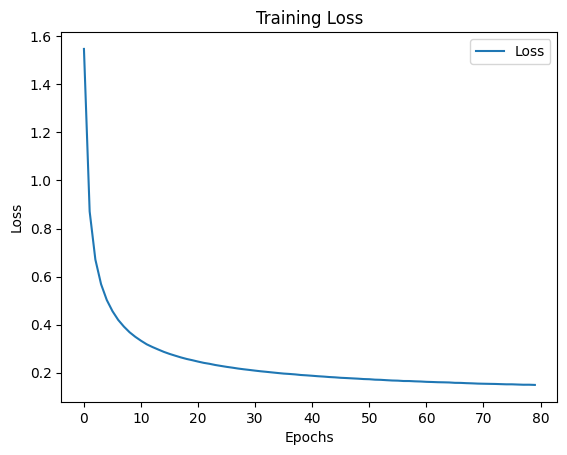

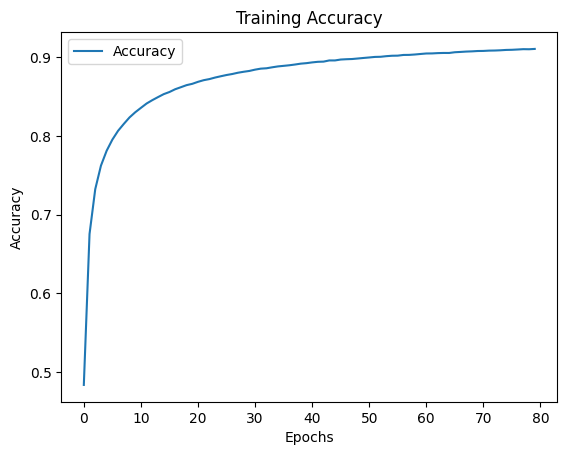

In [14]:

# Plotting loss for the first language pair
plt.plot(losses_list, label='Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.savefig('training_loss.png')  # Save the loss plot as an image
plt.show()
plt.close()  # Close the plot to start a new one

# Plotting accuracies for the first language pair
plt.plot(accuracies_list, label='Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.savefig('training_accuracy.png')  # Save the accuracy plot as an image
plt.show()
plt.close()  # Close the plot


In [15]:
# Save Lists

# Save list as a pickle object

loss_filename = f'objects/bahdanau_loss_{LANGUAGE2}_{LANGUAGE1}.pkl'
accuracy_filename = f'objects/bahdanau_accuracy_{LANGUAGE2}_{LANGUAGE1}.pkl'

with open(loss_filename, 'wb') as file:
    pickle.dump(losses_list, file)

with open(accuracy_filename, 'wb') as file:
    pickle.dump(accuracies_list, file)